**A CNN TO CLASSIFY CANCER CELLS (using transfer learning)**

THE DATASET CAN BE FOUND HERE https://drive.google.com/drive/folders/165_yoc-oxJ7jxUkPhZmBq8CPJ35T27Yj?usp=sharing

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
from torchvision.models.vgg import VGG16_Weights
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

import helper

batch_size = 30
dir='/content/drive/MyDrive/CANCERDATASET'

train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.ToTensor()])

valid_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(dir+'/train', transform = train_transforms)
test_data = datasets.ImageFolder(dir+'/test', transform = test_transforms)
valid_data = datasets.ImageFolder(dir+'/valid', transform = valid_transforms)


trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

loaders_transfer = {'train': trainloader, 'valid': validloader, 'test': testloader}


**VISUALIZING THE DATA**

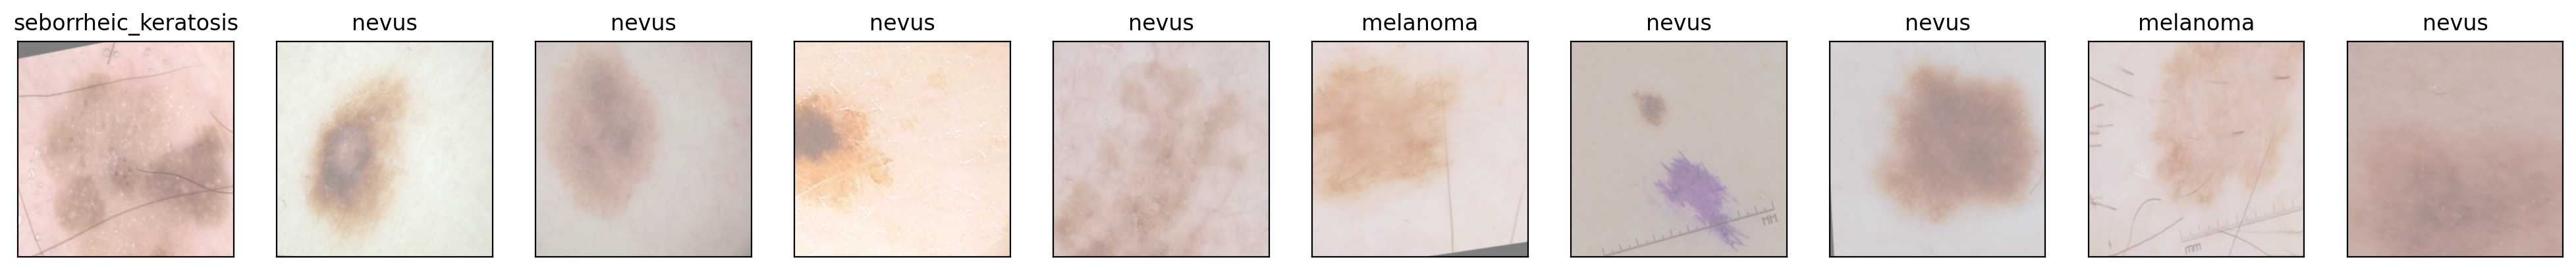

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

data_iter = iter(trainloader)
images,labels = next(data_iter)
images = images.numpy()

fig = plt.figure(figsize=(30, 8))
for idx in np.arange(10):
    ax = fig.add_subplot(1, 12, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])


**CHECKING INPUT SHAPE**


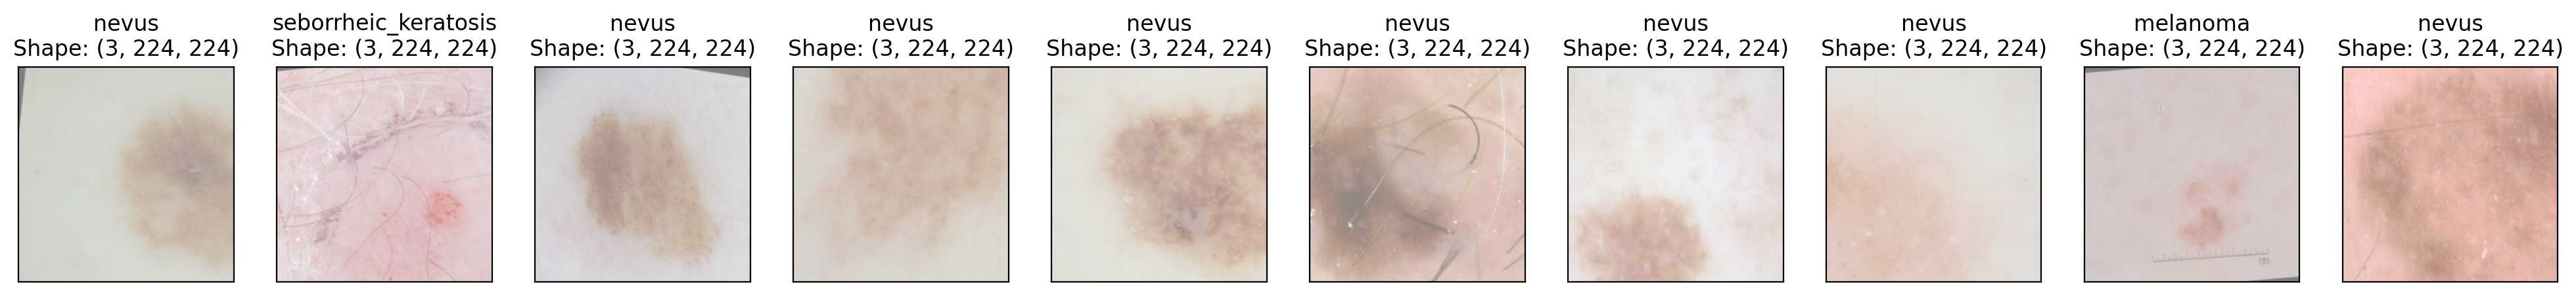

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

data_iter = iter(trainloader)
images, labels = next(data_iter)
images = images.numpy()

fig = plt.figure(figsize=(30, 8))
for idx in np.arange(10):
    ax = fig.add_subplot(1, 12, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    # Display the shape of each image as a title
    shape_info = images[idx].shape
    ax.set_title(f"{classes[labels[idx]]}\nShape: {shape_info}")

plt.show()


In [ ]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

**SPECIFY LOSS FUNCTION AND OPTIMIZER**

In [ ]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):

    optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
    return optimizer

**MODEL ARCHITECTURE**

In [ ]:
model_transfer = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

print(model_transfer)

for param in model_transfer.features.parameters():
    param.requires_grad = False

n_input = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_input,3)
model_transfer.classifier[6]=last_layer

if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**TRAIN AND VALIDATE THE MODEL**

In [ ]:
!pip install wandb -qU

In [ ]:
import wandb
wandb.login()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
num_epochs = 60
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # Initialize wandb
    wandb.init(
        project='your_project_name',
        config={
        "learning_rate": optimizer.param_groups[0]['lr'],
        "epochs": n_epochs,
        "batch_size": loaders['train'].batch_size
    })

    # Add the model to wandb
    wandb.watch(model, criterion, log='all', log_freq=10)

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################

        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            train_loss = train_loss + ((1/(batch_idx + 1)) * (loss.data.item() - train_loss))




        ######################
        # validate the model #
        ######################

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            valid_loss = valid_loss + ((1/(batch_idx + 1)) * (loss.data.item() - valid_loss))



        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))
        # Log metrics to wandb
        wandb.log({"epoch": epoch, "training_loss": train_loss, "validation_loss": valid_loss})

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss



    return model



In [ ]:
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer.pt')

model_transfer.load_state_dict(torch.load('model_transfer.pt'))

wandb: Currently logged in as: nglemmanuel. Use `wandb login --relogin` to force relogin


Epoch: 1 	Training Loss: 795.1037 	Validation Loss: 752.1981
Validation loss decreased (inf --> 752.1981).  Saving model ...
Epoch: 2 	Training Loss: 757.2449 	Validation Loss: 680.9601
Validation loss decreased (752.1981 --> 680.9601).  Saving model ...
Epoch: 3 	Training Loss: 746.3879 	Validation Loss: 682.7632
Epoch: 4 	Training Loss: 712.2376 	Validation Loss: 704.9711
Epoch: 5 	Training Loss: 681.3403 	Validation Loss: 653.8841
Validation loss decreased (680.9601 --> 653.8841).  Saving model ...
Epoch: 6 	Training Loss: 699.3884 	Validation Loss: 659.6558
Epoch: 7 	Training Loss: 668.9412 	Validation Loss: 647.0300
Validation loss decreased (653.8841 --> 647.0300).  Saving model ...
Epoch: 8 	Training Loss: 683.7993 	Validation Loss: 652.2929
Epoch: 9 	Training Loss: 669.5110 	Validation Loss: 630.2946
Validation loss decreased (647.0300 --> 630.2946).  Saving model ...
Epoch: 10 	Training Loss: 678.7088 	Validation Loss: 621.3719
Validation loss decreased (630.2946 --> 621.3719)

<All keys matched successfully>

**(IMPLEMENTATION) TEST THE MODEL**

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.


    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.723540


Test Accuracy: 70% (422/600)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score

def test(loaders, model, criterion, use_cuda):
    test_loss = 0.
    correct = 0.
    total = 0.

    # Collect all the probabilities and true labels
    all_probs = []
    all_labels = []

    model.eval()
    with torch.no_grad():  # No need to track gradients during testing
        for batch_idx, (data, target) in enumerate(loaders['test']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            loss = criterion(output, target)
            test_loss += (loss.data.item() - test_loss) / (batch_idx + 1)

            # Calculate probabilities (softmax) on the output
            probabilities = torch.softmax(output, dim=1)
            all_probs.append(probabilities.cpu().numpy())
            all_labels.append(target.cpu().numpy())

            pred = output.max(1, keepdim=True)[1]  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.size(0)

        # Concatenate all batches
        all_probs = np.concatenate(all_probs, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        # Compute ROC AUC score
        if len(np.unique(all_labels)) > 2:  # Check if it is a multiclass classification
            roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
            print('ROC AUC Score: {:.4f}'.format(roc_auc))
        else:  # Binary classification fallback
            roc_auc = roc_auc_score(all_labels, all_probs[:, 1])
            print('ROC AUC Score: {:.4f}'.format(roc_auc))

    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy: {:.2f}% ({}/{})'.format(100. * correct / total, correct, total))

# Load the model and run the test
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)


ROC AUC Score: 0.7916
Test Loss: 0.723540

Test Accuracy: 70.33% (422.0/600.0)


ROC compute

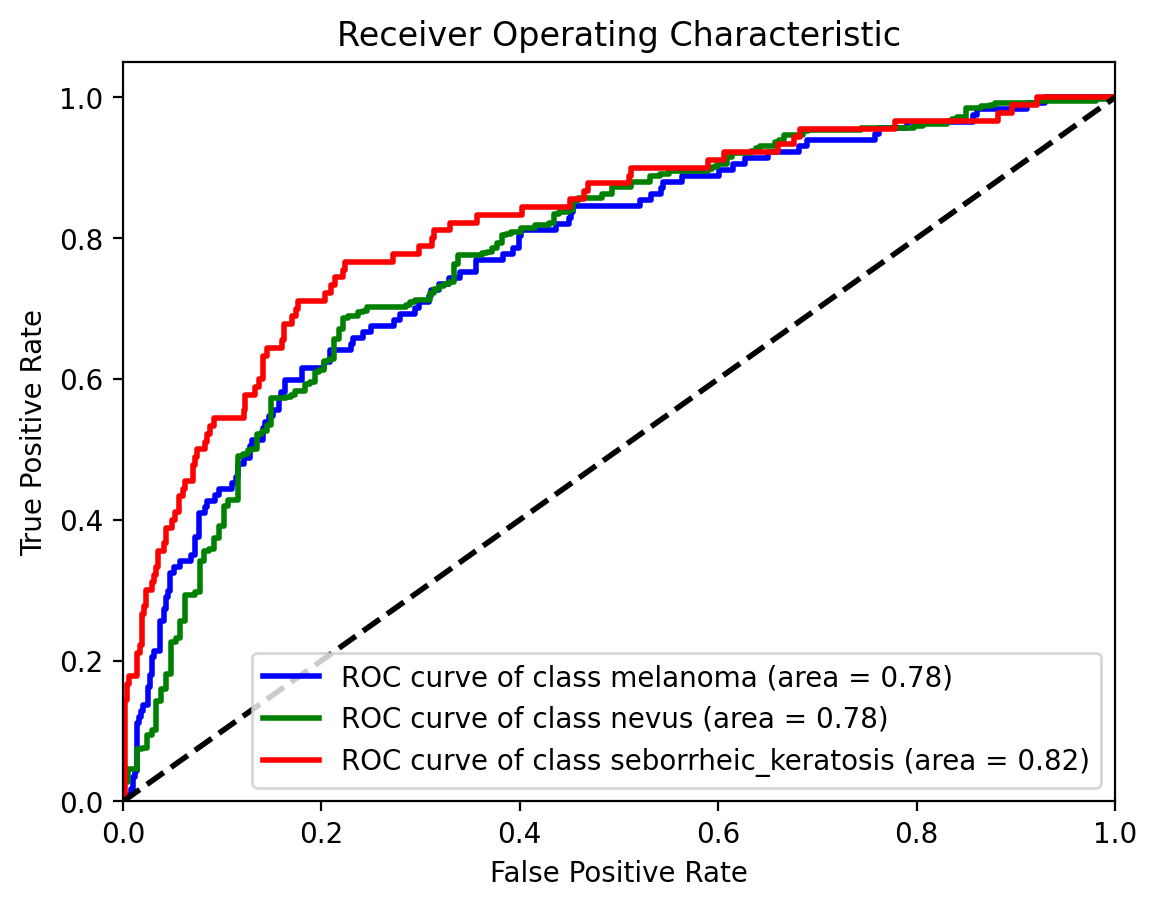

Test Loss: 0.723540

Test Accuracy: 70.33% (422.0/600.0)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def test(loaders, model, criterion, use_cuda):
    test_loss = 0.
    correct = 0.
    total = 0.

    all_probs = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loaders['test']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            loss = criterion(output, target)
            test_loss += (loss.data.item() - test_loss) / (batch_idx + 1)

            probabilities = torch.softmax(output, dim=1)
            all_probs.append(probabilities.cpu().numpy())
            all_labels.append(target.cpu().numpy())

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.size(0)

        all_probs = np.concatenate(all_probs, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        # Compute ROC curve and ROC area for each class
        classes = loaders['test'].dataset.classes
        all_labels_binarized = label_binarize(all_labels, classes=np.arange(len(classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(len(classes)):
            fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plotting each class ROC curve
        colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
        for i, color in enumerate(colors[:len(classes)]):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy: {:.2f}% ({}/{})'.format(100. * correct / total, correct, total))

model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)


**PREDICTION ALGORITHM**

In [ ]:
import cv2
from PIL import Image

def cancer_predict(img_path, k):

    img = Image.open(img_path).convert('RGB')

    img_transforms = transforms.Compose([
                     transforms.Resize(256),
                     transforms.CenterCrop(224),
                     transforms.ToTensor(),
                     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])

                ])

    img = img_transforms(img)
    img.unsqueeze_(0)

    if use_cuda:
        img = img.cuda()

    output = model_transfer(img)
    top_values, top_idx = output.topk(k)

    top_classes = [classes[class_id] for class_id in top_idx[0].tolist()]
    return top_classes

# test on a sample image
cancer_predict('/content/drive/MyDrive/CANCERDATASET/test/nevus/ISIC_0012654.jpg', 2)

['nevus', 'melanoma']

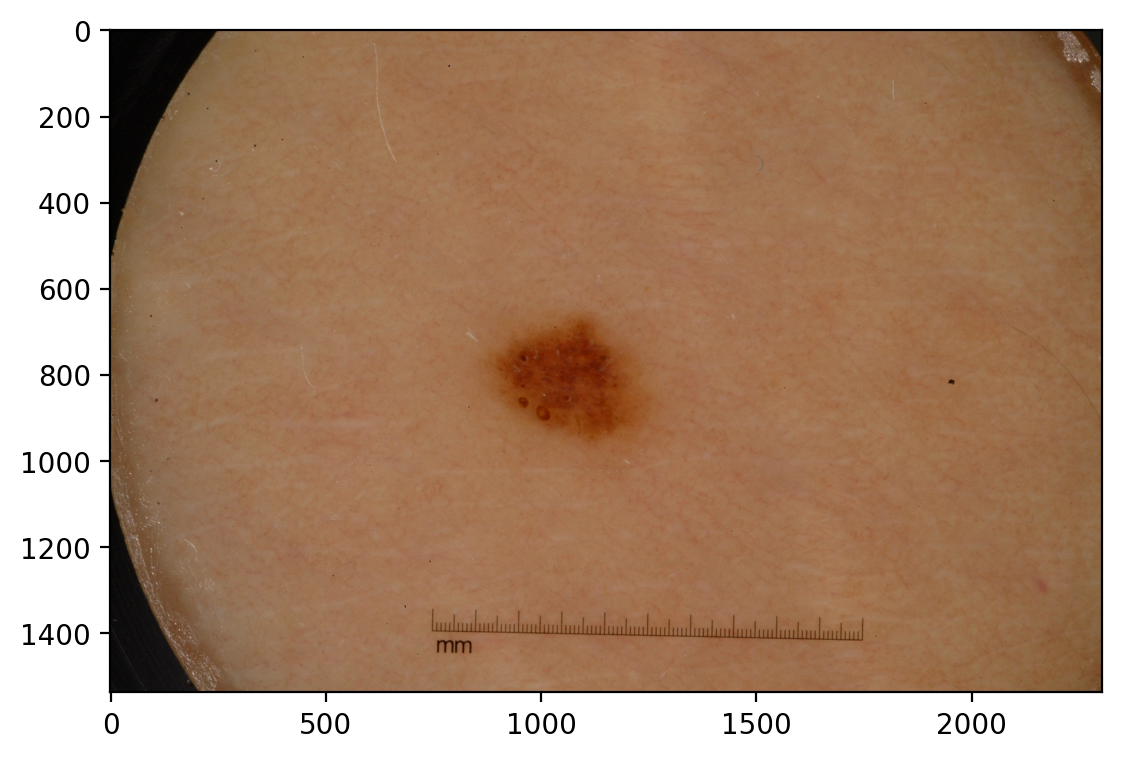

Actual Label: nevus
Predicted Label: 
 nevus


In [ ]:
def CheckCancerType(img_path):
    # get cancer cell predictions
    predicted_cancercell = cancer_predict(img_path, 3)

    #display image and display cancer predictions
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()

    print(f"Actual Label: {img_path.split('/')[-2]}")
    print(f"Predicted Label: \n {predicted_cancercell[0]}")



# test on a sample image
CheckCancerType('/content/drive/MyDrive/CANCERDATASET/test/nevus/ISIC_0012654.jpg')

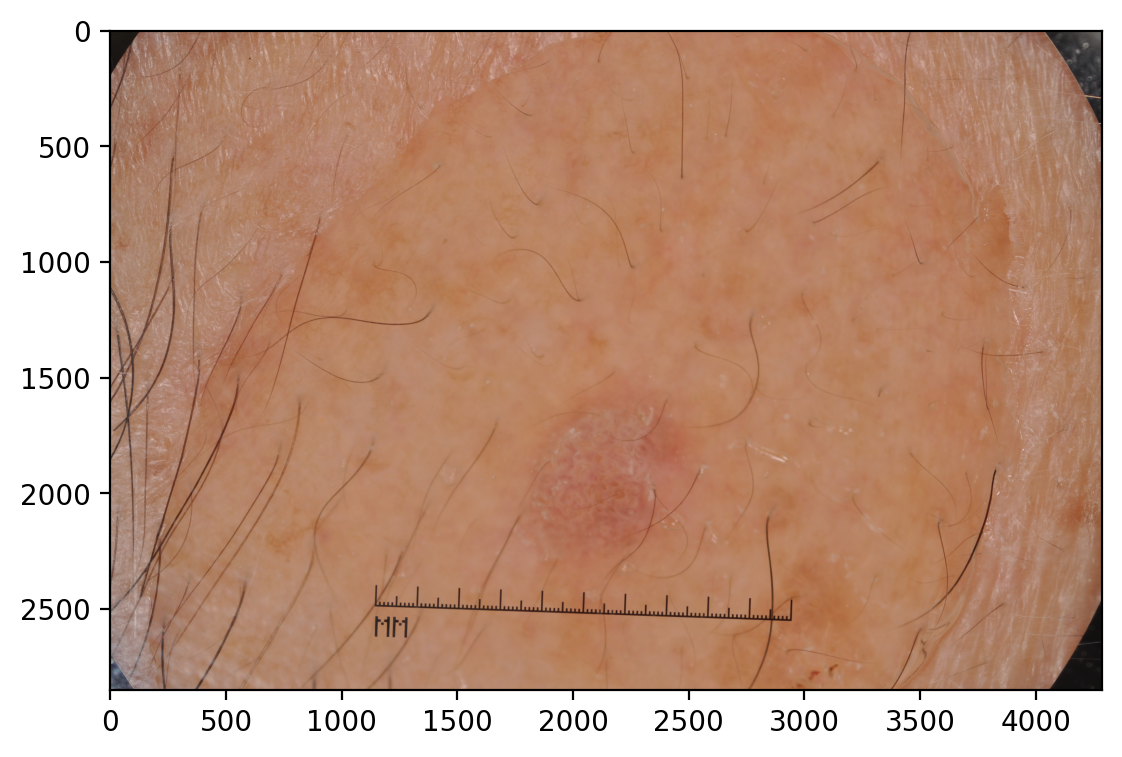

Actual Label: seborrheic_keratosis
Predicted Label: 
 melanoma


In [ ]:
def CheckCancerType(img_path):

    predicted_cancercell = cancer_predict(img_path, 3)

    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()

    print(f"Actual Label: {img_path.split('/')[-2]}")
    print(f"Predicted Label: \n {predicted_cancercell[0]}")



# test on a sample image
CheckCancerType('/content/drive/MyDrive/CANCERDATASET/test/seborrheic_keratosis/ISIC_0014177.jpg')

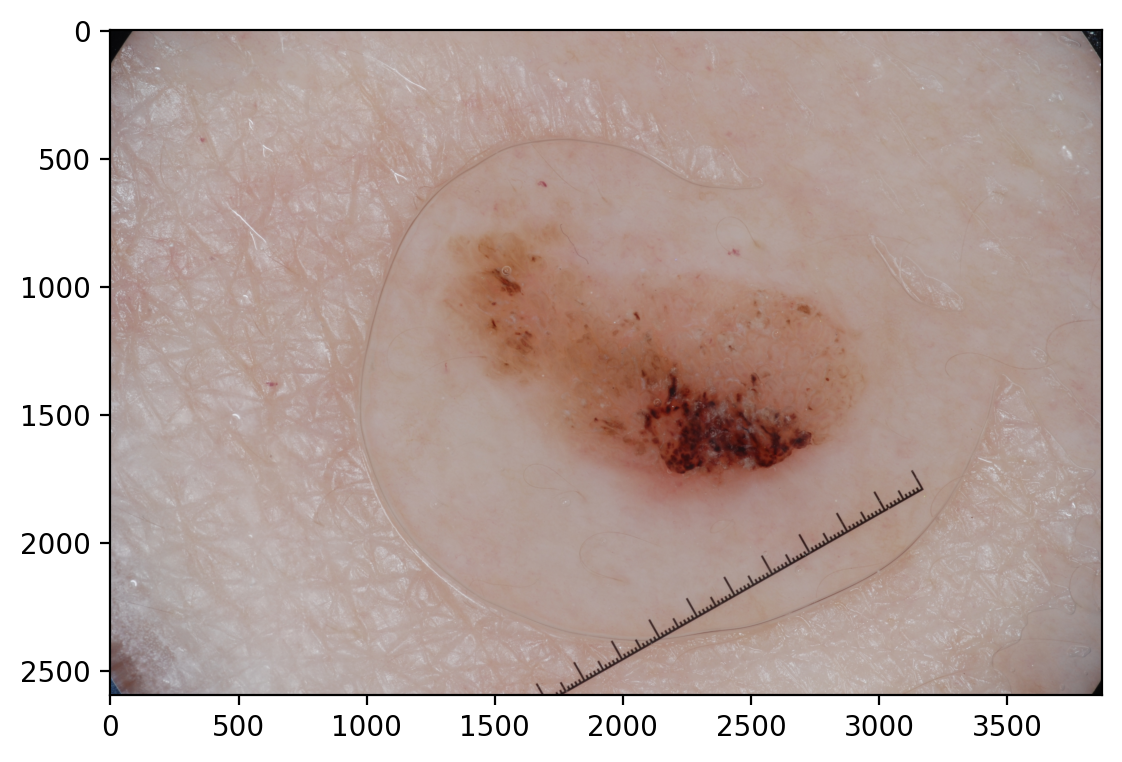

Actual Label: seborrheic_keratosis
Predicted Label: 
 seborrheic_keratosis


In [ ]:
def CheckCancerType(img_path):

    predicted_cancercell = cancer_predict(img_path, 3)

    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()

    print(f"Actual Label: {img_path.split('/')[-2]}")
    print(f"Predicted Label: \n {predicted_cancercell[0]}")



# test on a sample image
CheckCancerType('/content/drive/MyDrive/CANCERDATASET/test/seborrheic_keratosis/ISIC_0012757.jpg')